In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
pd.set_option('display.max_columns', None)
import math
from scipy.integrate import odeint

mash tun dimensions

In [2]:
radius = 0.15
height = 0.75

In [3]:
volume = math.pi * math.pow(radius, 2) * height
volume

0.053014376029327764

In [4]:
surface = 2 * math.pi * radius * height + 2 * math.pi * math.pow(radius, 2)
surface

0.8482300164692441

In [5]:
# water specific heat https://en.wikipedia.org/wiki/Heat_capacity#Measurement
# in J/(kg⋅K)
Cp = 4185.5
heat_capacity = Cp * volume * 1000

# for low speed air convection, in W/(m^2*K)
heat_transfer_coefficient = 10

In [6]:
# ambient heat loss in Watts
heat_transfer_coefficient * surface * (75 - 25)

424.11500823462205

In [7]:
# time to heat to target temperature (seconds)
heat_capacity * (75 - 50) / 3000

1849.0972572562614

In [8]:
# https://en.wikipedia.org/wiki/Newton%27s_law_of_cooling
def temperature_derivative(temperature, time, power, external_temperature, 
                  heat_capacity, heat_transfer_coefficient, surface):
    return (power - heat_transfer_coefficient * surface * (temperature - external_temperature)) / heat_capacity

In [9]:
time = np.arange(0, 3000, 10, dtype=np.float64)
power = np.full_like(time, 3000)
external_temperature = np.full_like(time, 20)
temperature = np.full_like(time, np.nan)
temperature[0] = 50
setpoint = np.full_like(time, 75)

In [10]:
for i in range(len(time) - 1):
    temperature[i+1] = odeint(temperature_derivative, temperature[i], time[i:(i+2)], 
                              args=(power[i], external_temperature[i], heat_capacity, heat_transfer_coefficient, surface),
                             )[-1]

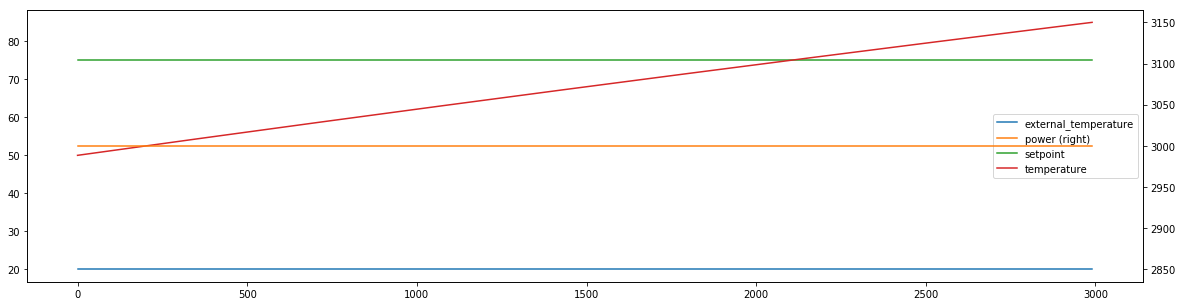

In [11]:
pd.DataFrame(index=time, data={'temperature':  temperature,
                               'external_temperature': external_temperature,
                               'setpoint': setpoint,
                               'power': power
                              }).plot(secondary_y=('power'));